In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import random
import itertools
from scipy.optimize import minimize, least_squares
from scipy.optimize import NonlinearConstraint
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.spatial import ConvexHull
from scipy.stats import zscore
from itertools import permutations, product

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.style.use('style.mpl')

# Models

## Heterotrophy

Set of metabolites are:
<ul>
    <li> Corg
    <li> NAD
    <li> NADH
    <li> O2
    <li> ATP
    <li> ADP
    <li> CO2
    <li> biomass
</ul>

Set of parameters are:

<ul>
    <li> $\nu_{supply}$
    <li> $\gamma$'s
    <li> $\phi$'s
    <li> total ATP/ADP and NADH/NAD+ pools
</ul>

TODO: add $phi_o$?

In [4]:
eps = 1e-10

In [5]:
def het_model( t, y ):
    x = y.copy()
    x[x<eps] = 0.0
    Corg = x[0]
    NADH = x[1]
    O2 = x[2]
    ATP = x[3]
    
    NAD = r1 * NADH
    ADP = r2 * ATP
    
    sum_phis = phi_cat + phi_resp + phi_ana
    assert(np.abs(sum_phis - 1) < 1e-4)
    
    KM_term_cat = 1 + (Corg/KM)*((NAD/KM)** 2)
    nu_cat = Corg * (NAD ** 2) * phi_cat / (gamma_cat*KM_term_cat)
    
    KM_term_resp = 1 + (O2/KM)*((NADH/KM)**2)
    nu_resp = (NADH ** 2) * O2 * phi_resp / (gamma_resp*KM_term_resp)
    
    KM_term_ana = 1 + (Corg/KM)*((NADH/KM)**S6)*((ATP/KM)**S6)
    nu_ana = (Corg * (NADH ** S6) * (ATP ** S5) * phi_ana / 
              (gamma_ana*KM_term_ana))
    
    mu = nu_ana.copy()
    
    dCorg = - nu_cat - nu_ana + nu_supply - mu * Corg
    dNADH = 2 * nu_cat - 2 * nu_resp - S6 * nu_ana - mu * NADH
    #dNADH = 0.0
    dNAD = - dNADH
    dO2 = 0.0
    dATP = S3 * nu_cat + S4 * nu_resp - S5 * nu_ana - mu * ATP
    dADP = -dATP
    
    dydt = np.nan_to_num(np.array([dCorg, dNADH, dO2, dATP]))
    return dydt

# Simulations

### Parameters

In [6]:
# fluxes are in mol C / g / s
nu_supply = 1

# gammas are in (g s)/(mol) units.
gamma_cat = 50
gamma_resp = 200
gamma_ana = 50

In [7]:
phi_cat = 0.5
phi_ana = 0.4
phi_resp = 0.1

In [8]:
S4 = 4
S3 = 0.3
S5 = 1
S6 = 0.2

### Initial conditions

In [9]:
# micromolar concentrations
Corg0 = 1e3
NADH0 = 1e4
O20 = 1e4
ATP0 = 1e4

# KM is in uM
KM = 100
r1 = 10.
r2 = 0.1

In [10]:
# Testing out the terms w saturation
NAD0 = r1*NADH0
KM_term_cat = 1 + (Corg0/KM)*((NAD0/KM)** 2)
nu_cat = Corg0 * (NAD0 ** 2) * phi_cat / (gamma_cat*KM_term_cat)
print(KM_term_cat)
print(nu_cat)
print()

KM_term_resp = 1 + (O20/KM)*((NADH0/KM)**2)
nu_resp = (NADH0 ** 2) * O20 * phi_resp / (gamma_resp*KM_term_resp)
print(KM_term_resp)
print(nu_resp)
print()

KM_term_ana = 1 + (Corg0/KM)*((NADH0/KM)**S6)*((ATP0/KM)**S5)
nu_ana = (Corg0 * (NADH0 ** S6) * (ATP0 ** S5) * phi_ana / 
          (gamma_ana*KM_term_ana))
print(KM_term_ana)
print(nu_ana)
print(phi_ana/gamma_ana)
print((NADH0 ** S6))
print((ATP0 ** S5))


10000001.0
9999.9990000001

1000001.0
499.9995000005

2512.8864315095802
200.870946356666
0.008
6.309573444801933
10000.0


### Dynamics

In [11]:
y0 = np.array([ Corg0, NADH0, O20, ATP0 ])
NUM_METS = len(y0)

# Evaluation time
TFINAL = 1e6
t = np.logspace(-4, 6, 1000 )

In [12]:
y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau' ).y

### Plot

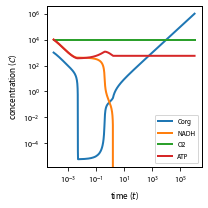

In [13]:
fig, ax = plt.subplots( 1, 1, figsize=(3, 3) )

ax.set_ylabel( 'concentration (' + r'$\mathcal{C}$)')
ax.set_xlabel( 'time (' + r'$t$)')
for idx in range(NUM_METS):
    ax.plot( t[:len(y_sol[idx])], y_sol[idx], lw=2)
ax.legend([ 'Corg', 'NADH', 'O2', 'ATP' ], loc='best')
ax.set_yscale('log')
ax.set_xscale('log')

fig.tight_layout()
plt.show()

### Fluxes

In [14]:
def give_nus( y_sol, tpt ):
    x = y_sol[:, tpt].copy()
    Corg = x[0]
    NADH = x[1]
    O2 = x[2]
    ATP = x[3]

    NAD = r1 * NADH
    ADP = r2 * ATP

    nu_cat = Corg * (NAD ** 2) * phi_cat / gamma_cat
    nu_resp = (NADH ** 2) * O2 * phi_resp / gamma_resp
    nu_ana = Corg * (NADH ** S6) * (ATP ** S5) * phi_ana / gamma_ana
    
    # rescale to mmol/gDW/hr from mol/gDW/s
    return 3.6e6*np.array([nu_cat, nu_resp, nu_ana])

In [15]:
nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

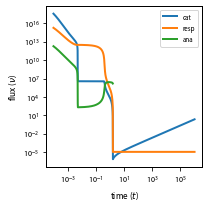

In [19]:
fig, ax = plt.subplots( 1, 1, figsize=(3, 3) )

ax.set_ylabel( 'flux (' + r'$\nu$)')
ax.set_xlabel( 'time (' + r'$t$)')
for idx in range(3):
    ax.plot( t[:len(nus[idx])], nus[idx], lw=2 )
ax.legend([ 'cat', 'resp', 'ana' ], loc='best')
ax.set_yscale('log')
ax.set_xscale('log')

fig.tight_layout()
plt.show()

In [17]:
phi_resp_vals = np.linspace(0.0, 0.5, 6)[1:]
phi_resp_vals

array([0.1, 0.2, 0.3, 0.4, 0.5])

# Sweeping over $\phi_{ana} + \phi_{cat}$

In [18]:
res = dict(mu=[], nu_cat=[], nu_resp=[], nu_ana=[], phi_cat=[], phi_ana=[], phi_resp=[])

for t_phi_resp in phi_resp_vals:
    print('resp fraction', t_phi_resp)
    phi_resp = t_phi_resp.copy()
    cat_ana_total = 1-t_phi_resp
    for t_phi_ana in np.logspace(-6, np.log10(cat_ana_total), 300):
        phi_ana = t_phi_ana.copy()
        phi_cat = cat_ana_total - t_phi_ana

        y0 = np.array([ Corg0, NADH0, O20, ATP0 ])
        NUM_METS = len(y0)

        # Evaluation time
        TFINAL = 1e7
        t = np.logspace(-4, 6, 1000 )
        S6 = 0.2

        y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau' ).y

        nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

        res['mu'].append(nus[-1, -1])
        for i, nu in enumerate('nu_cat,nu_resp,nu_ana'.split(',')):
            res[nu].append(nus[i, -1])
        res['phi_ana'].append(t_phi_ana)
        res['phi_cat'].append(phi_cat.copy())
        res['phi_resp'].append(t_phi_resp)

resp fraction 0.1


KeyboardInterrupt: 

In [ ]:
res_df = pd.DataFrame(res).replace({np.NaN:0})
res_df

In [ ]:
fig, ax = plt.subplots( 1, 1, figsize=(5, 5) )

plt.ylabel( r'$\mu$' )
plt.xlabel( r'$\phi_{ana}$' )

mask = res_df.phi_resp == res_df.phi_resp.max()
ax.plot(res_df[mask].phi_ana, res_df[mask].mu, lw=5)
plt.twiny()
ax.plot(res_df[mask].phi_cat, res_df[mask].mu, lw=5)
plt.xlabel(r'$\phi_{cat}$', labelpad=10)

# ax.set_yscale('log')
# ax.set_xscale('log')

fig.tight_layout()
plt.show()

In [ ]:
plt.figure()
plt.xscale('log')

pal = sns.color_palette('Reds')
for i, (idx, gdf) in enumerate(res_df.groupby('phi_resp')):
    plt.plot(gdf.phi_ana, gdf.mu, color=pal[i])

In [ ]:
plt.figure()
plt.xscale('log')

tmp = res_df.groupby('phi_resp').agg(dict(mu='idxmax'))
maxs = res_df.loc[tmp.mu]
pal = sns.color_palette('Reds', n_colors=maxs.mu.size)

for i, (idx, gdf) in enumerate(res_df.groupby('phi_resp')):
    plt.plot(gdf.nu_resp, gdf.nu_ana, color=pal[i])
    
tmp = res_df.groupby('phi_resp').agg(dict(mu='idxmax'))
maxs = res_df.loc[tmp.mu]

plt.scatter(maxs.nu_resp, maxs.mu, edgecolor='k', lw=2, color='w', zorder=10)
plt.xlabel('$\\nu_{resp}$')
plt.ylabel('$\\nu_{ana}$')
plt.show()

# Sweeping over $S_6$

In [ ]:
mus = []
zcs = []

phi_cat = 0.4
phi_resp = 0.05
phi_ana = 1-phi_cat-phi_resp

for S6 in np.linspace(-2., 2., 100):

    y0 = np.array([ Corg0, NADH0, O20, ATP0 ])
    NUM_METS = len(y0)

    # Evaluation time
    TFINAL = 1e6
    t = np.logspace(-4, 6, 1000 )

    y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau' ).y


    nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

    mus.append(nus[-1, -1])
    zcs.append(S6)

In [ ]:
fig, ax = plt.subplots( 1, 1, figsize=(5, 5) )

ax.set_ylabel( r'$\mu$' )
ax.set_xlabel( r'$S_6$' )
ax.plot( zcs, mus, lw=5 )
# ax.set_yscale('log')
# ax.set_xscale('log')
fig.tight_layout()
plt.show()